# Machine Learning in the NBA Draft 
# by Tim Krumwiede

## The Wrangling Process

### Table of Contents
[1. Introduction](#intro)

[2. Draft Data](#draft)

[3. College Player Data](#player)

[4. College Team Data](#team)

<a id='draft'></a>

<a id='intro'></a>

### Introduction

My goal for this project is to build a machine learning pipeline for predicting the long-term success of a college player in the NBA. I see this as a drafting tool for NBA teams to use in informing their draft choices. Therefore, the training data will only be data available for particular player during their college career.

This is a supervised regression problem, so my training set will only include players that actually played in the NBA. I will also only use players that played in college after the 3-point shot was adopted, since that is such an important aspect of the game today.

After researching other similar projects online, I've decided to use three main sources of data: draft data from https://www.basketball-reference.com/play-index/draft_finder.cgi, individual college stats from www.sports-reference.com/cbb, and team college stats also from www.sports-reference.com/cbb.

### Draft Data

I'll start by loading the modules I'm going to use later.

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns

#this is an api that can be used to import data from sports-reference.com
from sportsreference.ncaab.roster import Roster as ncaa_roster 
from sportsreference.ncaab.teams import Teams as ncaa_teams

from IPython.display import clear_output

I was mildly frustrated with exporting data from the basketball-reference draft finder tool. Only one page of a search (100 results) can be exported at a time. I flirted with the idea of doing some kind of web scraping, but ultimately just downloaded each page by hand and appended them all into one excel file: draft.csv. Looking back, I should have better utilized bbref's draft finder tool to filter out players that never played in the NBA, but I'm not going to go back and do it now.

I was mildly frustrated with exporting data from the basketball-reference draft finder tool. Only one page of a search (100 results) can be exported at a time. I flirted with the idea of doing some kind of web scraping, but ultimately just downloaded each page by hand and appended them all into one csv file: draft.csv. Looking back, I should have better utilized bbref's draft finder tool to filter out players that never played in the NBA, but I'm not going to go back and do it now.

In [12]:
draft_data=pd.read_csv('draft.csv')#import csv file
draft_data.head()#display top 5 rows

,Rk,Year,Lg,Rd,Pk,Tm,Player,Age,Pos,Born,...,TRB,AST,STL,BLK,FG%,2P%,3P%,FT%,WS,WS/48
0,1.0,2018.0,NBA,1.0,1.0,PHO,Deandre Ayton,19.338,C,bs,...,10.3,1.8,0.9,0.9,0.585,0.588,0.000,0.746,5.8,0.128
1,2.0,2018.0,NBA,1.0,2.0,SAC,Marvin Bagley,19.104,F,us,...,7.6,1.0,0.5,1.0,0.504,0.534,0.313,0.691,3.6,0.110
2,3.0,2018.0,NBA,1.0,4.0,MEM,Jaren Jackson,18.284,F,us,...,4.7,1.1,0.9,1.4,0.506,0.553,0.359,0.766,3.3,0.105
3,4.0,2018.0,NBA,1.0,5.0,DAL,Trae Young,19.280,G,us,...,3.7,8.1,0.9,0.2,0.418,0.477,0.324,0.829,3.3,0.062
4,5.0,2018.0,NBA,1.0,6.0,ORL,Mohamed Bamba,20.045,C,us,...,5.0,0.8,0.3,1.4,0.481,0.555,0.300,0.587,1.7,0.106


In [5]:
draft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3088 entries, 0 to 3087
Data columns (total 26 columns):
Rk         3086 non-null float64
Year       3086 non-null float64
Lg         3086 non-null object
Rd         3086 non-null float64
Pk         3086 non-null float64
Tm         3086 non-null object
Player     3086 non-null object
Age        1838 non-null float64
Pos        1838 non-null object
Born       1838 non-null object
College    3086 non-null object
From       1809 non-null float64
To         1809 non-null float64
G          1809 non-null float64
MP         1809 non-null float64
PTS        1809 non-null float64
TRB        1809 non-null float64
AST        1809 non-null float64
STL        1809 non-null float64
BLK        1809 non-null float64
FG%        1804 non-null float64
2P%        1802 non-null float64
3P%        1635 non-null float64
FT%        1768 non-null float64
WS         1809 non-null float64
WS/48      1808 non-null float64
dtypes: float64(20), object(6)
memory usa

Really all I need right now from this data is a list of college players that played in the NBA, their colleges and the year they were drafted. The columns "Rd", "Pk", and "Tm" refer to the order in which players were drafted and by which team, so I don't need those. The basketball stats at the bottom all refer to players' performance in the NBA, so I don't want that either (at least not yet), though I am going to use Games Played ("G") to filter out those who didn't end up actually playing.

In [30]:
draft_data=draft_data[draft_data.G > 0]#players who played at least one game in the NBA
draft_data=draft_data[['Player','Year','Age','Pos','College']]#these are the columns I can use
draft_data['Year']=draft_data.Year.astype(int)#recasting Year as an int
draft_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1809 entries, 0 to 3053
Data columns (total 5 columns):
Player     1809 non-null object
Year       1809 non-null int32
Age        1809 non-null float64
Pos        1809 non-null object
College    1809 non-null object
dtypes: float64(1), int32(1), object(3)
memory usage: 157.7+ KB


<a id='player'></a>

### College Player Data

I'm going to use the sports-reference api I loaded above to look up college stats for each player in draft_data. The documentation can be found at https://sportsreference.readthedocs.io/en/stable/ncaab.html.

There's a big problem though: looking up a player requires knowing either the player's code or the college abbreviation used by the API. After looking through the list of college abbreviations, I was able to decipher most of the rules for taking the full name of a college (which is the value in the "College" column of draft data) and converting it to the college abbreviation we need for the API.

In [14]:
def to_college_code(colleges): #colleges is expected to be of the pandas series type
    college_code=colleges.str.replace('University','')# strip out substring 'University'
    college_code=college_code.str.replace('of ','')#More operations that convert to the college abbreviation used by the API
    college_code=college_code.str.replace(',','')#...
    college_code=college_code.str.replace('.','')
    college_code=college_code.str.replace('\'','')
    college_code=college_code.str.replace('College','')
    college_code=college_code.str.strip()
    college_code=college_code.str.upper()
    college_code=college_code.str.replace('   ','-')
    college_code=college_code.str.replace('  ','-')
    college_code=college_code.str.replace(' ','-')
    college_code=college_code.str.replace('AT-','')
    college_code=college_code.str.replace('CALIFORNIA-STATE','CAL-STATE')
    college_code=college_code.str.replace('A&M','AM')
    college_code=college_code.str.replace('THE-','')
    
    #the operations above cover the vast majority of cases, but there are still some holdouts
    #I'm covering exceptions by slicing out the exception rows and assigning the correct abbreviation manually
    for i in college_code[college_code=='CALIFORNIA-LOS-ANGELES'].index:
        college_code[i]='UCLA'

    for i in college_code[college_code=='ILLINOIS-URBANA-CHAMPAIGN'].index:
        college_code[i]='ILLINOIS'
    
    for i in college_code[college_code=='NEVADA-RENO'].index:
        college_code[i]='NEVADA'

    for i in college_code[college_code=='GEORGIA-INSTITUTE-TECHNOLOGY'].index:
        college_code[i]='GEORGIA-TECH'    
    
    for i in college_code[colleges=='Boston College'].index:
        college_code[i]='BOSTON-COLLEGE'    
    
    for i in college_code[colleges=='Boston University'].index:
        college_code[i]='BOSTON-UNIVERSITY'  
    
    for i in college_code[college_code=='VIRGINIA-POLYTECHNIC-INSTITUTE-AND-STATE'].index:
        college_code[i]='VIRGINIA-TECH'
    
    for i in college_code[college_code=='TEXAS-AUSTIN'].index:
        college_code[i]='TEXAS'  

    for i in college_code[college_code=='ST-JOHNS'].index:
        college_code[i]='ST-JOHNS-NY' 
    
    for i in college_code[colleges=='University of Miami'].index:
        college_code[i]='MIAMI-FL'    
    
    for i in college_code[colleges=='Miami University'].index:
        college_code[i]='MIAMI-OH' 
    
    for i in college_code[college_code=='LOYOLA-CHICAGO'].index:
        college_code[i]='LOYOLA-IL'  

    for i in college_code[college_code=='LOYOLA-IN-MARYLAND'].index:
        college_code[i]='LOYOLA-MD' 
    
    for i in college_code[college_code=='FLORIDA-AGRICULTURAL-AND-MECHANICAL'].index:
        college_code[i]='FLORIDA-AM' 
    
    for i in college_code[college_code=='CAL-STATE-FRESNO'].index:
        college_code[i]='FRESNO-STATE' 
    
    for i in college_code[college_code=='CAL-STATE-LONG-BEACH'].index:
        college_code[i]='LONG-BEACH-STATE' 
    
    for i in college_code[college_code=='TENNESSEE-TECHNOLOGICAL'].index:
        college_code[i]='TENNESSEE-TECH' 
    
    for i in college_code[college_code=='INDIANA--PURDUE-INDIANAPOLIS'].index:
        college_code[i]='IUPUI' 
    
    for i in college_code[college_code=='SAINT-MARYS-CALIFORNIA'].index:
        college_code[i]='SAINT-MARYS-CA' 
    
    for i in college_code[college_code=='MIDDLE-TENNESSEE-STATE'].index:
        college_code[i]='MIDDLE-TENNESSEE' 
    
    for i in college_code[college_code=='AUSTIN-PEAY-STATE'].index:
        college_code[i]='AUSTIN-PEAY'  
    
    for i in college_code[college_code=='MASSACHUSETTS-AMHERST'].index:
        college_code[i]='MASSACHUSETTS'  
    
    for i in college_code[college_code=='PENNSYLVANIA-STATE'].index:
        college_code[i]='PENN-STATE'
    
    for i in college_code[college_code=='LONG-ISLAND'].index:
        college_code[i]='LONG-ISLAND-UNIVERSITY'
    
    for i in college_code[college_code=='UNITED-STATES-NAVAL-ACADEMY'].index:
        college_code[i]='NAVY'
        
    return college_code #return the new series


In [33]:
#creating a new column with the college abbreviations
draft_data['college_code'] = to_college_code(draft_data.College)

In [34]:
draft_data.head()

,Player,Year,Age,Pos,College,college_code
0,Deandre Ayton,2018,19.338,C,University of Arizona,ARIZONA
1,Marvin Bagley,2018,19.104,F,Duke University,DUKE
2,Jaren Jackson,2018,18.284,F,Michigan State University,MICHIGAN-STATE
3,Trae Young,2018,19.280,G,University of Oklahoma,OKLAHOMA
4,Mohamed Bamba,2018,20.045,C,University of Texas at Austin,TEXAS


In [37]:
sample_player_df=ncaa_roster(team='DUKE').players[1].dataframe
ncaa_columns=list(sample_player_df.columns)
cfirst_columns=['cfirst_' + col for col in ncaa_columns]
clast_columns=['clast_' + col for col in ncaa_columns]

In [ ]:
data=pd.concat([draft_data,pd.DataFrame(columns=cfirst_columns)],sort=False)
data=pd.concat([data,pd.DataFrame(columns=clast_columns)],sort=False)

In [ ]:
for r in data.iterrows():
    i=r[0]
    row=r[1]
    clear_output(wait=True)
    print(i)
    try:
        for player in ncaa_roster(team=row.college_code,year=row.Year).players:
            if player.name:
                if row.Player in player.name:
                    first=player.dataframe.iloc[0,:]
                    first.index=['cfirst_'+s for s in list(first.keys())]
                    data.loc[i,cfirst_columns]=first
                    last=player.dataframe.iloc[-2,:]
                    last.index=['clast_'+s for s in list(last.keys())]
                    data.loc[i,clast_columns]=last
                    break
                
        for player in ncaa_roster(team=row.college_code,year=(row.Year-1)).players:
            if player.name:
                if row.Player in player.name:
                    first=player.dataframe.iloc[0,:]
                    first.index=['cfirst_'+s for s in list(first.keys())]
                    data.loc[i,cfirst_columns]=first
                    last=player.dataframe.iloc[-2,:]
                    last.index=['clast_'+s for s in list(last.keys())]
                    data.loc[i,clast_columns]=last
                    break
                
    except:
        pass

In [ ]:
data.to_csv('raw_data.csv',index=False,header=True)

In [41]:
data=pd.read_csv('raw_data.csv',index_col=False)
missing_players=data[data.clast_points.isnull()].Player
missing_players.describe()

count                 95
unique                95
top       Kenny Williams
freq                   1
Name: Player, dtype: object

In [42]:
for i in missing_players.index:
    clear_output(wait=True)
    print(i)
    row=data.loc[i,:]
    lastname=row.Player
    if ' Jr.' in lastname:
        lastname=lastname.replace(' Jr.','')
    elif ' III' in lastname:
        lastname=lastname.replace(' III','')
    lastname=lastname.split(' ')[-1]
    
    try:
        for player in ncaa_roster(team=row.college_code,year=row.Year).players:
            if player.name:
                if lastname in player.name:
                    first=player.dataframe.iloc[0,:]
                    first.index=['cfirst_'+s for s in list(first.keys())]
                    data.loc[i,cfirst_columns]=first
                    last=player.dataframe.iloc[-2,:]
                    last.index=['clast_'+s for s in list(last.keys())]
                    data.loc[i,clast_columns]=last
                    break

    except:
        pass
missing_players=data[data.clast_points.isnull()].Player
missing_players.describe()

1625


count               58
unique              58
top       Qyntel Woods
freq                 1
Name: Player, dtype: object

In [43]:
data=data.drop(missing_players.index)

In [44]:
data=data[data.Year>1987]

In [45]:
data=data.drop(columns=['clast_conference','clast_height','clast_player_id','clast_position','clast_team_abbreviation','clast_weight'])
data=data.drop(columns=['cfirst_conference','cfirst_height','cfirst_player_id','cfirst_position','cfirst_team_abbreviation','cfirst_weight'])

for s in ['clast_conference','clast_height','clast_player_id','clast_position','clast_team_abbreviation','clast_weight']:
    clast_columns.remove(s)
for s in ['cfirst_conference','cfirst_height','cfirst_player_id','cfirst_position','cfirst_team_abbreviation','cfirst_weight']:
    cfirst_columns.remove(s)

In [50]:
cfirst_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, cfirst_columns))

cfirst_missing={}
for col in cfirst_missing_cols:
    cfirst_missing[col]=data[col].isnull().sum()
cfirst_missing

{'cfirst_assist_percentage': 680,
 'cfirst_assists': 2,
 'cfirst_block_percentage': 680,
 'cfirst_blocks': 2,
 'cfirst_box_plus_minus': 933,
 'cfirst_defensive_box_plus_minus': 933,
 'cfirst_defensive_rebound_percentage': 896,
 'cfirst_defensive_rebounds': 592,
 'cfirst_defensive_win_shares': 429,
 'cfirst_effective_field_goal_percentage': 78,
 'cfirst_field_goal_attempts': 1,
 'cfirst_field_goal_percentage': 1,
 'cfirst_field_goals': 1,
 'cfirst_free_throw_attempt_rate': 1,
 'cfirst_free_throw_attempts': 1,
 'cfirst_free_throw_percentage': 5,
 'cfirst_free_throws': 1,
 'cfirst_games_played': 1,
 'cfirst_games_started': 300,
 'cfirst_minutes_played': 29,
 'cfirst_offensive_box_plus_minus': 933,
 'cfirst_offensive_rebound_percentage': 896,
 'cfirst_offensive_rebounds': 592,
 'cfirst_offensive_win_shares': 429,
 'cfirst_personal_fouls': 35,
 'cfirst_player_efficiency_rating': 906,
 'cfirst_points': 1,
 'cfirst_points_produced': 896,
 'cfirst_steal_percentage': 888,
 'cfirst_steals': 2,
 

Many of these are missing only one value. On closer inspection, there is a single player in the set who did not play at all in his first year in college.

In [54]:
first_missing=data[data.cfirst_field_goal_attempts.isnull()].index

In [60]:
#data=data.drop(first_missing)

cfirst_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, cfirst_columns))

cfirst_missing={}
for col in cfirst_missing_cols:
    cfirst_missing[col]=data[col].isnull().sum()
cfirst_missing

{'cfirst_assist_percentage': 679,
 'cfirst_assists': 1,
 'cfirst_block_percentage': 679,
 'cfirst_blocks': 1,
 'cfirst_box_plus_minus': 932,
 'cfirst_defensive_box_plus_minus': 932,
 'cfirst_defensive_rebound_percentage': 895,
 'cfirst_defensive_rebounds': 591,
 'cfirst_defensive_win_shares': 428,
 'cfirst_effective_field_goal_percentage': 77,
 'cfirst_free_throw_percentage': 4,
 'cfirst_games_started': 299,
 'cfirst_minutes_played': 28,
 'cfirst_offensive_box_plus_minus': 932,
 'cfirst_offensive_rebound_percentage': 895,
 'cfirst_offensive_rebounds': 591,
 'cfirst_offensive_win_shares': 428,
 'cfirst_personal_fouls': 34,
 'cfirst_player_efficiency_rating': 905,
 'cfirst_points_produced': 895,
 'cfirst_steal_percentage': 887,
 'cfirst_steals': 1,
 'cfirst_three_point_attempt_rate': 77,
 'cfirst_three_point_attempts': 77,
 'cfirst_three_point_percentage': 245,
 'cfirst_three_pointers': 77,
 'cfirst_total_rebound_percentage': 680,
 'cfirst_turnover_percentage': 39,
 'cfirst_turnovers': 3

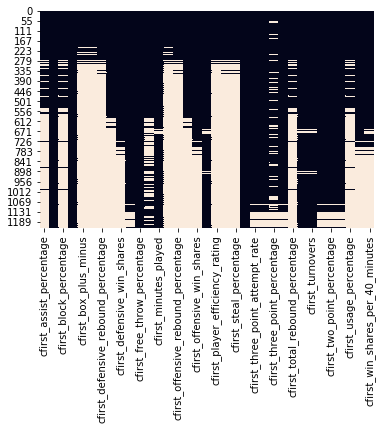

In [61]:
sns.heatmap(data[cfirst_missing_cols].isnull(), cbar=False)

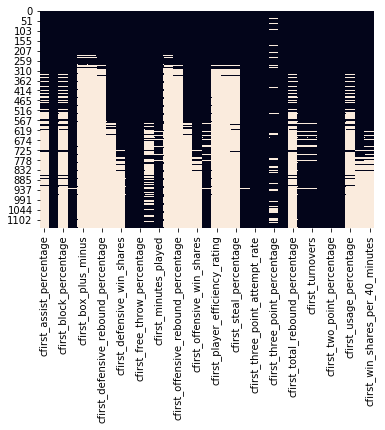

In [69]:
data=data[~data.cfirst_two_pointers.isnull()]
sns.heatmap(data[cfirst_missing_cols].isnull(), cbar=False)

In [73]:
for i in data[data.cfirst_three_point_percentage.isnull()].index:
    data.loc[i,'cfirst_three_point_percentage']=0

In [92]:
data=data.drop(columns=['cfirst_box_plus_minus','cfirst_defensive_box_plus_minus','cfirst_offensive_box_plus_minus'])
for s in ['cfirst_box_plus_minus','cfirst_defensive_box_plus_minus','cfirst_offensive_box_plus_minus']:
    cfirst_columns.remove(s)
    cfirst_missing_cols.remove(s)

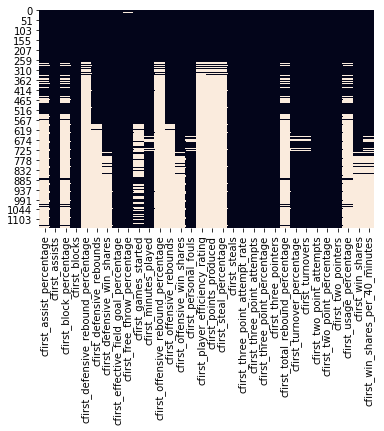

In [93]:
sns.heatmap(data[cfirst_missing_cols].isnull(), cbar=False)

In [96]:
cfirst_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, cfirst_columns))

cfirst_missing={}
for col in cfirst_missing_cols:
    cfirst_missing[col]=data[col].isnull().sum()
cfirst_missing

{'cfirst_assist_percentage': 604,
 'cfirst_block_percentage': 604,
 'cfirst_blocks': 1,
 'cfirst_defensive_rebound_percentage': 817,
 'cfirst_defensive_rebounds': 513,
 'cfirst_defensive_win_shares': 350,
 'cfirst_free_throw_percentage': 3,
 'cfirst_games_started': 279,
 'cfirst_minutes_played': 28,
 'cfirst_offensive_rebound_percentage': 817,
 'cfirst_offensive_rebounds': 513,
 'cfirst_offensive_win_shares': 350,
 'cfirst_personal_fouls': 34,
 'cfirst_player_efficiency_rating': 827,
 'cfirst_points_produced': 817,
 'cfirst_steal_percentage': 809,
 'cfirst_steals': 1,
 'cfirst_total_rebound_percentage': 605,
 'cfirst_turnover_percentage': 33,
 'cfirst_turnovers': 33,
 'cfirst_usage_percentage': 605,
 'cfirst_win_shares': 350,
 'cfirst_win_shares_per_40_minutes': 378}

In [97]:
for i in data[data.cfirst_blocks.isnull()].index:
    data.loc[i,'cfirst_blocks']=0

for i in data[data.cfirst_free_throw_percentage.isnull()].index:
    data.loc[i,'cfirst_free_throw_percentage']=0
    
for i in data[data.cfirst_steals.isnull()].index:
    data.loc[i,'cfirst_steals']=0

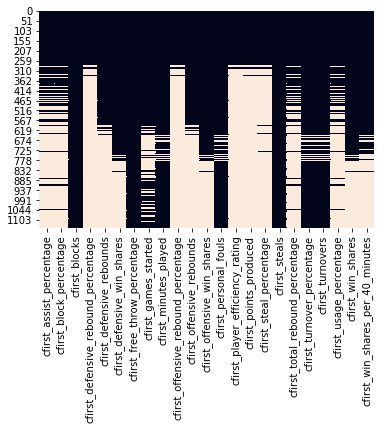

In [100]:
sns.heatmap(data[cfirst_missing_cols].isnull(), cbar=False)

In [75]:
clast_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, clast_columns))

clast_missing={}
for col in clast_missing_cols:
    clast_missing[col]=data[col].isnull().sum()
clast_missing

{'clast_assist_percentage': 551,
 'clast_block_percentage': 551,
 'clast_box_plus_minus': 784,
 'clast_defensive_box_plus_minus': 784,
 'clast_defensive_rebound_percentage': 746,
 'clast_defensive_rebounds': 441,
 'clast_defensive_win_shares': 255,
 'clast_games_started': 267,
 'clast_minutes_played': 40,
 'clast_offensive_box_plus_minus': 784,
 'clast_offensive_rebound_percentage': 746,
 'clast_offensive_rebounds': 441,
 'clast_offensive_win_shares': 255,
 'clast_personal_fouls': 43,
 'clast_player_efficiency_rating': 784,
 'clast_points_produced': 746,
 'clast_steal_percentage': 743,
 'clast_three_point_attempt_rate': 1,
 'clast_three_point_attempts': 1,
 'clast_three_point_percentage': 79,
 'clast_total_rebound_percentage': 551,
 'clast_turnover_percentage': 43,
 'clast_turnovers': 43,
 'clast_two_point_attempts': 1,
 'clast_two_point_percentage': 1,
 'clast_usage_percentage': 551,
 'clast_win_shares': 255,
 'clast_win_shares_per_40_minutes': 294}

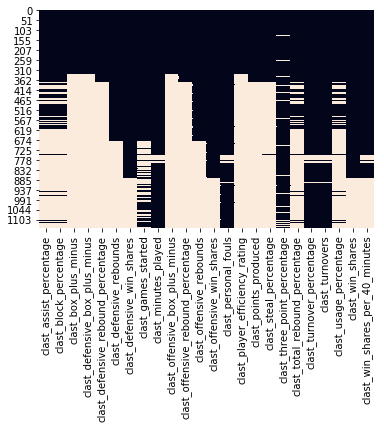

In [76]:
data=data[~data.clast_two_point_percentage.isnull()]

clast_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, clast_columns))

clast_missing={}
for col in clast_missing_cols:
    clast_missing[col]=data[col].isnull().sum()
sns.heatmap(data[clast_missing_cols].isnull(), cbar=False)

In [77]:
for i in data[data.clast_three_point_percentage.isnull()].index:
    data.loc[i,'clast_three_point_percentage']=0

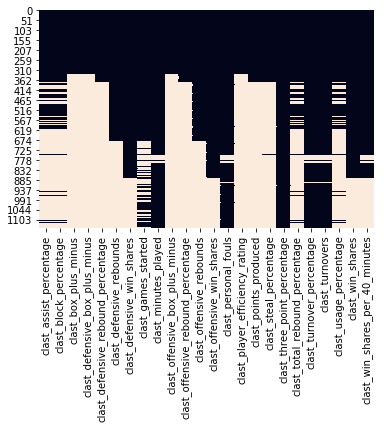

In [98]:
sns.heatmap(data[clast_missing_cols].isnull(), cbar=False)

In [99]:
clast_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, clast_columns))

clast_missing={}
for col in clast_missing_cols:
    clast_missing[col]=data[col].isnull().sum()
clast_missing

{'clast_assist_percentage': 550,
 'clast_block_percentage': 550,
 'clast_box_plus_minus': 783,
 'clast_defensive_box_plus_minus': 783,
 'clast_defensive_rebound_percentage': 745,
 'clast_defensive_rebounds': 440,
 'clast_defensive_win_shares': 254,
 'clast_games_started': 266,
 'clast_minutes_played': 40,
 'clast_offensive_box_plus_minus': 783,
 'clast_offensive_rebound_percentage': 745,
 'clast_offensive_rebounds': 440,
 'clast_offensive_win_shares': 254,
 'clast_personal_fouls': 43,
 'clast_player_efficiency_rating': 783,
 'clast_points_produced': 745,
 'clast_steal_percentage': 742,
 'clast_total_rebound_percentage': 550,
 'clast_turnover_percentage': 43,
 'clast_turnovers': 43,
 'clast_usage_percentage': 550,
 'clast_win_shares': 254,
 'clast_win_shares_per_40_minutes': 293}

In [101]:
data.to_csv('player_data.csv',index=False,header=True)

<a id='team'></a>

### College Team Data

In [109]:
o_columns=pd.read_excel('team_data/2018o.xls',header=1).columns
o_columns_rename=['Rk', 'School', 'G', 'W', 'L', 'W-L%', 'SRS', 'SOS', 'W.1', 'L.1',
       'W.2', 'L.2', 'W.3', 'L.3', 'Tm.', 'Opp.', 'Unnamed: 16', 'opp_MP', 'opp_FG',
       'opp_FGA', 'opp_FG%', 'opp_3P', 'opp_3PA', 'opp_3P%', 'opp_FT', 'opp_FTA', 'opp_FT%', 'opp_ORB', 'opp_TRB',
       'opp_AST', 'opp_STL', 'opp_BLK', 'opp_TOV', 'opp_PF']
o_columns_merge=['Rk', 'opp_MP', 'opp_FG',
       'opp_FGA', 'opp_FG%', 'opp_3P', 'opp_3PA', 'opp_3P%', 'opp_FT', 'opp_FTA', 'opp_FT%', 'opp_ORB', 'opp_TRB',
       'opp_AST', 'opp_STL', 'opp_BLK', 'opp_TOV', 'opp_PF']

In [116]:
ao_columns=pd.read_excel('team_data/2018ao.xls',header=1).columns
ao_columns_rename=['Rk', 'School', 'G', 'W', 'L', 'W-L%', 'SRS', 'SOS', 'W.1', 'L.1',
       'W.2', 'L.2', 'W.3', 'L.3', 'Tm.', 'Opp.', 'Unnamed: 16', 'opp_Pace',
       'opp_ORtg', 'opp_FTr', 'opp_3PAr', 'opp_TS%', 'opp_TRB%', 'opp_AST%', 'opp_STL%', 'opp_BLK%', 'opp_eFG%',
       'opp_TOV%', 'opp_ORB%', 'opp_FT/FGA']
ao_columns_merge=['Rk', 'opp_Pace',
       'opp_ORtg', 'opp_FTr', 'opp_3PAr', 'opp_TS%', 'opp_TRB%', 'opp_AST%', 'opp_STL%', 'opp_BLK%', 'opp_eFG%',
       'opp_TOV%', 'opp_ORB%', 'opp_FT/FGA']

In [119]:
team_data=pd.read_excel('team_data/2018.xls',header=1)
team_data['Year']=2018

temp1=pd.read_excel('team_data/2018a.xls',header=1)
merge_cols_a=list(set(temp1.columns) - set(team_data.columns))+['Rk']
team_data=team_data.merge(temp1[merge_cols_a] ,
                             how='outer',on='Rk',copy=False)

temp2=pd.read_excel('team_data/2018o.xls',header=1)
temp2.columns=o_columns_rename
team_data=team_data.merge(temp2[o_columns_merge] ,
                             how='outer',on='Rk',copy=False)

temp3=pd.read_excel('team_data/2018ao.xls',header=1)
temp3.columns=ao_columns_rename
team_data=team_data.merge(temp3[ao_columns_merge] ,
                             how='outer',on='Rk',copy=False)


for i in range(2017,2009,-1):
    file='team_data/' + str(i) + '.xls'
    file_a='team_data/' + str(i) + 'a.xls'
    file_o='team_data/' + str(i) + 'o.xls'
    file_ao='team_data/' + str(i) + 'ao.xls'
    
    temp=pd.read_excel(file,header=1)
    temp['Year']=i
    temp=temp.merge(pd.read_excel(file_a,header=1)[merge_cols_a],
                             how='outer',on='Rk',copy=False)
    temp2=pd.read_excel(file_o,header=1)
    temp2.columns=o_columns_rename
    temp=temp.merge(temp2[o_columns_merge] ,
                             how='outer',on='Rk',copy=False)
    
    temp3=pd.read_excel(file_ao,header=1)
    temp3.columns=ao_columns_rename
    temp=temp.merge(temp3[ao_columns_merge] ,
                             how='outer',on='Rk',copy=False)
    
    team_data=team_data.append(temp,ignore_index=True,sort=False)
team_data

,Rk,School,G,W,L,W-L%,SRS,SOS,W.1,L.1,...,opp_3PAr,opp_TS%,opp_TRB%,opp_AST%,opp_STL%,opp_BLK%,opp_eFG%,opp_TOV%,opp_ORB%,opp_FT/FGA
0,1,Abilene Christian,32,16,16,0.500,-9.14,-6.82,8.0,10.0,...,0.374,0.540,50.3,48.1,8.9,7.5,0.499,19.5,28.4,0.298
1,2,Air Force,31,12,19,0.387,-4.31,1.72,6.0,12.0,...,0.431,0.576,51.3,57.2,8.3,10.6,0.549,18.3,27.8,0.234
2,3,Akron,32,14,18,0.438,-6.82,-1.92,6.0,12.0,...,0.401,0.567,50.8,51.1,9.0,11.7,0.532,16.2,27.9,0.277
3,4,Alabama A&M,31,3,28,0.097,-23.97,-8.04,3.0,15.0,...,0.323,0.562,51.8,52.2,11.1,13.8,0.540,14.4,32.1,0.204
4,5,Alabama-Birmingham,33,20,13,0.606,4.90,-0.65,10.0,8.0,...,0.437,0.524,45.2,53.2,10.0,7.7,0.498,15.9,24.6,0.183
5,6,Alabama State,31,8,23,0.258,-18.55,-8.62,8.0,10.0,...,0.352,0.556,52.1,51.4,9.4,9.9,0.519,15.5,34.7,0.319
6,7,Alabama NCAA,36,20,16,0.556,12.34,10.64,8.0,10.0,...,0.379,0.514,49.7,48.7,9.4,10.5,0.478,16.0,30.8,0.250
7,8,Albany (NY),32,22,10,0.688,0.01,-5.41,10.0,6.0,...,0.362,0.533,44.8,53.7,8.2,10.1,0.506,15.2,24.3,0.195
8,9,Alcorn State,32,11,21,0.344,-18.07,-8.60,7.0,11.0,...,0.410,0.541,51.6,57.6,8.9,8.8,0.505,16.0,31.2,0.270
9,10,American,30,6,24,0.200,-14.63,-6.17,3.0,15.0,...,0.325,0.582,54.9,53.1,10.3,11.9,0.549,17.8,30.9,0.291
